## Elo Merchant Category Recommendation

### Import libraries

In [0]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import os
import time
import warnings
import gc
gc.collect()
import pickle
import os
from six.moves import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from collections import Counter

244

In [0]:
#Add All the Models Libraries

# Scalers
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# Models

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from scipy.stats import reciprocal, uniform

from sklearn.model_selection import StratifiedKFold, RepeatedKFold

# Cross-validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate

# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Common data processors
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from scipy import sparse
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

### Loading data

In [ ]:
#Using Kaggle datasets in Colab
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# Next, install the Kaggle API client.
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
# Copy the stackoverflow data set locally.
!kaggle competitions download -c elo-merchant-category-recommendation

  0% 0.00/1.13M [00:00<?, ?B/s]
100% 1.13M/1.13M [00:00<00:00, 75.1MB/s]
  0% 0.00/17.2k [00:00<?, ?B/s]
100% 17.2k/17.2k [00:00<00:00, 14.3MB/s]
 67% 33.0M/49.4M [00:01<00:01, 12.1MB/s]
100% 49.4M/49.4M [00:01<00:00, 42.6MB/s]
 71% 9.00M/12.7M [00:01<00:00, 7.99MB/s]
100% 12.7M/12.7M [00:01<00:00, 8.74MB/s]
  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 99.2MB/s]
 97% 529M/548M [00:11<00:00, 44.1MB/s]
100% 548M/548M [00:11<00:00, 48.4MB/s]
  0% 0.00/846k [00:00<?, ?B/s]
100% 846k/846k [00:00<00:00, 55.7MB/s]
  0% 0.00/17.2k [00:00<?, ?B/s]
100% 17.2k/17.2k [00:00<00:00, 16.7MB/s]


In [0]:
#Extract zip files
import zipfile
for file in ['/content/sample_submission.csv.zip','/content/historical_transactions.csv.zip','/content/train.csv.zip','/content/test.csv.zip', '/content/new_merchant_transactions.csv.zip', '/content/merchants.csv.zip' ]:
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

## 4. Feature engineering functions

In [0]:
#Reduce the memory usage - Inspired by Panchajanya Banerjee
#determine and apply the smallest data type that can fit the range of values
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    '''
    Reduce the memory usage by applying the smallest data type that can fit the range of values
    '''
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
def aggregate_transaction_hist(trans, prefix):  
    '''
    Create aggrgate features from all hitorical transaction features
    '''
    agg_func = {
          'purchase_amount' : ['sum','max','min','mean','var','skew'],
          'installments' : ['sum','max','mean','var','skew'],
          'purchase_date' : ['max','min'],
          'month_lag' : ['max','min','mean','var','skew'],
          'month_diff' : ['max','min','mean','var','skew'],
          'weekend' : ['sum', 'mean'],
          'weekday' : ['sum', 'mean'],
          'authorized_flag': ['sum', 'mean'],
          'category_1': ['sum','mean', 'max','min'],
          'card_id' : ['size','count'],
          'month': ['nunique', 'mean', 'min', 'max'],
          'hour': ['nunique', 'mean', 'min', 'max'],
          'weekofyear': ['nunique', 'mean', 'min', 'max'],
          'day': ['nunique', 'mean', 'min', 'max'],
          'subsector_id': ['nunique'],
          'merchant_id': ['nunique'],
          'merchant_category_id' : ['nunique'],
          'price' :['sum','mean','max','min','var'],
          'duration' : ['mean','min','max','var','skew'],
          'amount_month_ratio':['mean','min','max','var','skew']
        
      }
    
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() 
                           for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (trans.groupby('card_id')
            .size()
            .reset_index(name='{}transactions_count'.format(prefix)))
    
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
    return agg_trans

In [0]:
def aggregate_transaction_new(trans, prefix):  
    '''
    Create aggrgate features from all new_transactions features
    '''        
    agg_func = {
          'purchase_amount' : ['sum','max','min','mean','var','skew'],
          'installments' : ['sum','max','mean','var','skew'],
          'purchase_date' : ['max','min'],
          'month_lag' : ['max','min','mean','var','skew'],
          'month_diff' : ['max','min','mean','var','skew'],
          'weekend' : ['sum', 'mean'],
          'weekday' : ['sum', 'mean'],
          'authorized_flag': ['sum', 'mean'],
          'category_1': ['sum','mean', 'max','min'],
          'card_id' : ['size','count'],
          'month': ['nunique', 'mean', 'min', 'max'],
          'hour': ['nunique', 'mean', 'min', 'max'],
          'weekofyear': ['nunique', 'mean', 'min', 'max'],
          'day': ['nunique', 'mean', 'min', 'max'],
          'subsector_id': ['nunique'],
          'merchant_category_id' : ['nunique'],
          'price' :['sum','mean','max','min','var'],
          'duration' : ['mean','min','max','var','skew'],
          'amount_month_ratio':['mean','min','max','var','skew']
    }
    
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() 
                           for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (trans.groupby('card_id')
            .size()
            .reset_index(name='{}transactions_count'.format(prefix)))
    
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
    return agg_trans

In [0]:
def merchants_agg(merchants):
    '''
    Aggrgating with Mean and mode for various features
    '''
    mode2 = lambda x: Counter(x).most_common(1)[0][0]
    merchants = merchants.groupby("merchant_id",as_index=False).agg({
        "merchant_group_id": mode2,
        "merchant_category_id": mode2,
        "subsector_id": mode2,
        "numerical_1": "mean",
        "numerical_2": "mean",
        "category_1": mode2,
        "most_recent_sales_range": mode2,
        "most_recent_purchases_range": mode2,
        "avg_sales_lag3": "mean",
        "avg_purchases_lag3": "mean",
        "active_months_lag3": mode2,
        "avg_sales_lag6": "mean",
        "avg_purchases_lag6": "mean",
        "active_months_lag6": mode2,
        "avg_sales_lag12": "mean",
        "avg_purchases_lag12": "mean",
        "active_months_lag12": mode2,
        "category_4": mode2,
        "city_id": mode2,
        "state_id": mode2,
        "category_2": mode2
    })

    return merchants

In [0]:
#Aggregating by card_id since there are duplicated card_id's:
#Numerical features: mean (without missings)
#Non-numerical features: mode
def new_transactions_agg(new_transactions):
    '''
    Aggrgating with Mean and mode for various features
    '''
    mode2 = lambda x: Counter(x).most_common(1)[0][0]
    new_transactions = new_transactions.groupby("card_id",as_index=False).agg({
        "authorized_flag": mode2,
        "merchant_category_id": mode2,
        "subsector_id": mode2,
        "merchant_id":  mode2,
        "category_1": mode2,
        'month_lag': mode2,
        "installments": mode2,
        "purchase_amount": "mean",
        "city_id": mode2,
        "state_id": mode2,
        "category_2": mode2,
        "purchase_date": mode2
    })
    return new_transactions

In [0]:
#Aggregating by card_id since there are duplicated card_id's:
def mean_encode(train, new_transactions, merchants, suffix):
    '''
    target Mean encoding of categorical features
    '''
    new_transactions = new_transactions_agg(new_transactions)
    new_transactions.columns = [col+suffix if col not in ["card_id", "merchant_id"] else col for col in new_transactions.columns]

    # Select only train card_id's
    train_new_trans = pd.merge(train['card_id'], new_transactions, on='card_id',how='left')
    del new_transactions

    # Similarly Aggregating by merchant_id since there are some duplicated merchants_id with different features values:
    merchants = merchants_agg(merchants)

    #Adding Merchants features to train data
    merchants.columns = [col+"_merchants"+suffix if col!="merchant_id" else col for col in merchants.columns]
    all_transactions_merchants = pd.merge(train_new_trans, merchants, on='merchant_id',how='left')
    del merchants
    del train_new_trans
    del all_transactions_merchants['merchant_id']

    card_ids_train = train["card_id"].unique()
    idxs = all_transactions_merchants["card_id"].isin(list(card_ids_train))
    all_transactions_merchants_filter = all_transactions_merchants.loc[idxs]
    all_transactions_merchants_filter_target = all_transactions_merchants_filter.merge(train[["card_id",\
                                           "target"]],how="left",left_on="card_id",right_on="card_id")
    del all_transactions_merchants_filter
    gc.collect()

    all_transactions_merchants.fillna(-9999,inplace=True)


    # Mean encoding
    features_mean_encoding = ['authorized_flag'+suffix, 'category_1'+suffix, 'month_lag'+suffix, 'installments'+suffix,'category_2'+suffix,
        'numerical_1_merchants'+suffix, 'category_1_merchants'+suffix, 'most_recent_sales_range_merchants'+suffix,
        'most_recent_purchases_range_merchants'+suffix, 'active_months_lag3_merchants'+suffix, 
        'active_months_lag6_merchants'+suffix, 'active_months_lag12_merchants'+suffix, 'category_4_merchants'+suffix,
        'category_2_merchants'+suffix]

    for col in features_mean_encoding:
        mean_encoding = all_transactions_merchants_filter_target.groupby(col).target.mean()
        all_transactions_merchants[col+"_mean_encoded"] = all_transactions_merchants[col].\
                                                                 map(mean_encoding)
    del mean_encoding
    gc.collect()   
    return all_transactions_merchants

In [0]:
#Aggregating by card_id since there are duplicated card_id's:
def mean_encode_test(test, new_transactions, merchants, suffix):
    '''
    target Mean encoding of categorical features
    '''
    new_transactions = new_transactions_agg(new_transactions)
    new_transactions.columns = [col+suffix if col not in ["card_id", "merchant_id"] else col for col in new_transactions.columns]

    # Select only test card_id's
    test_new_trans = pd.merge(test['card_id'], new_transactions, on='card_id',how='left')
    del new_transactions
    
    # Similarly Aggregating by merchant_id since there are some duplicated merchants_id with different features values:
    merchants = merchants_agg(merchants)

    #Adding Merchants features to test data
    merchants.columns = [col+"_merchants"+suffix if col!="merchant_id" else col for col in merchants.columns]
    all_transactions_merchants = pd.merge(test_new_trans, merchants, on='merchant_id',how='left')
    del merchants
    del test_new_trans
    del all_transactions_merchants['merchant_id']

    all_transactions_merchants.fillna(-9999,inplace=True)
    gc.collect()
    print("all_transactions_merchants shape", all_transactions_merchants.shape)
    return all_transactions_merchants

#### Train function

In [0]:
def getfeatures_train(train, transactions = None, new_transactions = None, merchants = None):
  # create Outliers feature 
  '''
  create train features from historical, new and merchants trancactions
  '''
  train['outliers'] = 0
  train.loc[train['target'] < -30, 'outliers'] = 1
  train['outliers'].value_counts()
  # Mean encoding features with outlier feature
  for features in ['feature_1','feature_2','feature_3']:
      order_label = train.groupby([features])['outliers'].mean()
      train[features+"_mean"] = train[features].map(order_label)
      
  # Now extract the days and Qtr
  train['days'] = (date(2018, 2, 1) - train['first_active_month'].dt.date).dt.days
  train['quarter'] = train['first_active_month'].dt.quarter

  feature_cols = ['feature_1', 'feature_2', 'feature_3']
  for f in feature_cols:
      train['days_' + f] = train['days'] * train[f]
      train['days_' + f + '_ratio'] = train[f] / train['days']

  gc.collect()
  
  # Loading historical_transactions data
  transactions = reduce_mem_usage(pd.read_csv('../content/historical_transactions.csv', nrows = 1000))
  transactions.replace([-np.inf, np.inf], np.nan, inplace=True)
  print('Preprocessing hist_trans...')
  # Feature extraction historical transaction
  #impute missing values.
  transactions['category_2'] = transactions['category_2'].fillna(-9999,inplace=True)
  transactions['category_3'] = transactions['category_3'].fillna('-9999',inplace=True)
  transactions['merchant_id'] = transactions['merchant_id'].fillna('-9999',inplace=True)
  transactions['installments'].replace(-1, np.nan,inplace=True)
  transactions['installments'].replace(999, np.nan,inplace=True)
  transactions['purchase_amount'] = transactions['purchase_amount'].apply(lambda x: min(x, 0.8))
  # Feature engineering
  transactions['authorized_flag'] = transactions['authorized_flag'].map({'Y': 1, 'N': 0})
  transactions['category_1'] = transactions['category_1'].map({'Y': 1, 'N': 0})
  transactions['category_3'] = transactions['category_3'].map({'A':0, 'B':1, 'C':2})
  transactions['purchase_date'] = pd.to_datetime(transactions['purchase_date'])
  transactions['weekofyear'] = transactions['purchase_date'].dt.weekofyear
  transactions['month'] = transactions['purchase_date'].dt.month
  transactions['day'] = transactions['purchase_date'].dt.day
  transactions['weekday'] = transactions.purchase_date.dt.weekday
  transactions['weekend'] = (transactions.purchase_date.dt.weekday >=5).astype(int)
  transactions['hour'] = transactions['purchase_date'].dt.hour 
  transactions['month_diff'] = ((datetime.today() - transactions['purchase_date']).dt.days)//30
  transactions['month_diff'] += transactions['month_lag']
  transactions['duration'] = transactions['purchase_amount']*transactions['month_diff']
  transactions['amount_month_ratio'] = transactions['purchase_amount']/transactions['month_diff']
  transactions['price'] = transactions['purchase_amount'] / transactions['installments']

  gc.collect()

  agg_func = {
          'mean': ['mean'],
     }
  for col in ['category_2','category_3']:
      transactions[col+'_mean'] = transactions['purchase_amount'].groupby(transactions[col]).agg('mean')
      transactions[col+'_max'] = transactions['purchase_amount'].groupby(transactions[col]).agg('max')
      transactions[col+'_min'] = transactions['purchase_amount'].groupby(transactions[col]).agg('min')
      transactions[col+'_sum'] = transactions['purchase_amount'].groupby(transactions[col]).agg('sum')
      agg_func[col+'_mean'] = ['mean']
    
  gc.collect()

  # Create Aggregate features on historical transaction
  merge_hist = aggregate_transaction_hist(transactions, prefix='hist_')
  del transactions
  gc.collect()
  train = pd.merge(train, merge_hist, on='card_id',how='left')
  del merge_hist
  gc.collect()
      
  #Feature Engineering - Adding new features inspired by Chau's first kernel
  train['hist_purchase_date_max'] = pd.to_datetime(train['hist_purchase_date_max'])
  train['hist_purchase_date_min'] = pd.to_datetime(train['hist_purchase_date_min'])
  train['hist_purchase_date_diff'] = (train['hist_purchase_date_max'] - train['hist_purchase_date_min']).dt.days
  train['hist_purchase_date_average'] = train['hist_purchase_date_diff']/train['hist_card_id_size']
  train['hist_purchase_date_uptonow'] = (datetime.today() - train['hist_purchase_date_max']).dt.days
  train['hist_purchase_date_uptomin'] = (datetime.today() - train['hist_purchase_date_min']).dt.days
  train['hist_first_buy'] = (train['hist_purchase_date_min'] - train['first_active_month']).dt.days
  train['hist_last_buy'] = (train['hist_purchase_date_max'] - train['first_active_month']).dt.days

  for feature in ['hist_purchase_date_max','hist_purchase_date_min']:
      train[feature] = train[feature].astype(np.int64) * 1e-9
  gc.collect()

  #Loading data new_merchant_transactions
  new_transactions = reduce_mem_usage(pd.read_csv('/content/new_merchant_transactions.csv', nrows = 1000).sort_values('card_id',ascending=False))
  new_transactions.replace([-np.inf, np.inf], np.nan, inplace=True)
  print('Preprocessing new_trans...')

  # Feature extraction new transaction
  #impute missing values
  new_transactions['category_2'] = new_transactions['category_2'].fillna(-9999,inplace=True)
  new_transactions['category_3'] = new_transactions['category_3'].fillna('-9999',inplace=True)
  new_transactions['merchant_id'] = new_transactions['merchant_id'].fillna('-9999',inplace=True)
  new_transactions['installments'].replace(-1, np.nan,inplace=True)
  new_transactions['installments'].replace(999, np.nan,inplace=True)
  new_transactions['purchase_amount'] = new_transactions['purchase_amount'].apply(lambda x: min(x, 0.8))

  #Feature Engineering - Adding new features inspired by Chau's first kernel
  new_transactions['authorized_flag'] = new_transactions['authorized_flag'].map({'Y': 1, 'N': 0})
  new_transactions['category_1'] = new_transactions['category_1'].map({'Y': 1, 'N': 0})
  new_transactions['category_3'] = new_transactions['category_3'].map({'A':0, 'B':1, 'C':2}) 

  new_transactions['purchase_date'] = pd.to_datetime(new_transactions['purchase_date'])
  new_transactions['month'] = new_transactions['purchase_date'].dt.month
  new_transactions['weekofyear'] = new_transactions['purchase_date'].dt.weekofyear
  new_transactions['day'] = new_transactions['purchase_date'].dt.day
  new_transactions['weekday'] = new_transactions.purchase_date.dt.weekday
  new_transactions['weekend'] = (new_transactions.purchase_date.dt.weekday >=5).astype(int)
  new_transactions['hour'] = new_transactions['purchase_date'].dt.hour 
  new_transactions['month_diff'] = ((datetime.today() - new_transactions['purchase_date']).dt.days)//30
  new_transactions['month_diff'] += new_transactions['month_lag']

  # additional features
  new_transactions['duration'] = new_transactions['purchase_amount']*new_transactions['month_diff']
  new_transactions['amount_month_ratio'] = new_transactions['purchase_amount']/new_transactions['month_diff']
  new_transactions['price'] = new_transactions['purchase_amount'] / new_transactions['installments']

  aggs = {
          'mean': ['mean'],
      }

  for col in ['category_2','category_3']:
      new_transactions[col+'_mean'] = new_transactions['purchase_amount'].groupby(new_transactions[col]).agg('mean')
      new_transactions[col+'_max'] = new_transactions['purchase_amount'].groupby(new_transactions[col]).agg('max')
      new_transactions[col+'_min'] = new_transactions['purchase_amount'].groupby(new_transactions[col]).agg('min')
      new_transactions[col+'_var'] = new_transactions['purchase_amount'].groupby(new_transactions[col]).agg('var')
      aggs[col+'_mean'] = ['mean']

  gc.collect()

  # Create Aggregate features on new transaction
  merge_new = aggregate_transaction_new(new_transactions, prefix='new_')
  del new_transactions

  train = pd.merge(train, merge_new, on='card_id',how='left')
  del merge_new
  gc.collect()

  #Feature Engineering - Adding new features inspired by Chau's first kernel
  train['new_purchase_date_max'] = pd.to_datetime(train['new_purchase_date_max'])
  train['new_purchase_date_min'] = pd.to_datetime(train['new_purchase_date_min'])
  train['new_purchase_date_diff'] = (train['new_purchase_date_max'] - train['new_purchase_date_min']).dt.days
  train['new_purchase_date_average'] = train['new_purchase_date_diff']/train['new_card_id_size']
  train['new_purchase_date_uptonow'] = (datetime.today() - train['new_purchase_date_max']).dt.days
  train['new_purchase_date_uptomin'] = (datetime.today() - train['new_purchase_date_min']).dt.days
  train['new_first_buy'] = (train['new_purchase_date_min'] - train['first_active_month']).dt.days
  train['new_last_buy'] = (train['new_purchase_date_max'] - train['first_active_month']).dt.days
  for feature in ['new_purchase_date_max','new_purchase_date_min']:
      train[feature] = train[feature].astype(np.int64) * 1e-9
  gc.collect()

  #NEW Features referred from https://www.kaggle.com/mfjwr1/simple-lightgbm-without-blending
  train['card_id_total'] = train['new_card_id_size']+train['hist_card_id_size']
  train['card_id_cnt_total'] = train['new_card_id_count']+train['hist_card_id_count']
  train['card_id_cnt_ratio'] = train['new_card_id_count']/train['hist_card_id_count']
  train['purchase_amount_total'] = train['new_purchase_amount_sum']+train['hist_purchase_amount_sum']
  train['purchase_amount_mean'] = train['new_purchase_amount_mean']+train['hist_purchase_amount_mean']
  train['purchase_amount_max'] = train['new_purchase_amount_max']+train['hist_purchase_amount_max']
  train['purchase_amount_min'] = train['new_purchase_amount_min']+train['hist_purchase_amount_min']
  train['purchase_amount_ratio'] = train['new_purchase_amount_sum']/train['hist_purchase_amount_sum']
  train['month_diff_mean'] = train['new_month_diff_mean']+train['hist_month_diff_mean']
  train['month_diff_ratio'] = train['new_month_diff_mean']/train['hist_month_diff_mean']
  train['month_lag_mean'] = train['new_month_lag_mean']+train['hist_month_lag_mean']
  train['month_lag_max'] = train['new_month_lag_max']+train['hist_month_lag_max']
  train['month_lag_min'] = train['new_month_lag_min']+train['hist_month_lag_min']
  train['category_1_mean'] = train['new_category_1_mean']+train['hist_category_1_mean']
  train['installments_total'] = train['new_installments_sum']+train['hist_installments_sum']
  train['installments_mean'] = train['new_installments_mean']+train['hist_installments_mean']
  train['installments_max'] = train['new_installments_max']+train['hist_installments_max']
  train['installments_ratio'] = train['new_installments_sum']/train['hist_installments_sum']
  train['price_total'] = train['purchase_amount_total'] / train['installments_total']
  train['price_mean'] = train['purchase_amount_mean'] / train['installments_mean']
  train['price_max'] = train['purchase_amount_max'] / train['installments_max']
  train['duration_mean'] = train['new_duration_mean']+train['hist_duration_mean']
  train['duration_min'] = train['new_duration_min']+train['hist_duration_min']
  train['duration_max'] = train['new_duration_max']+train['hist_duration_max']
  train['amount_month_ratio_mean']=train['new_amount_month_ratio_mean']+train['hist_amount_month_ratio_mean']
  train['amount_month_ratio_min']=train['new_amount_month_ratio_min']+train['hist_amount_month_ratio_min']
  train['amount_month_ratio_max']=train['new_amount_month_ratio_max']+train['hist_amount_month_ratio_max']
  train['new_CLV'] = train['new_card_id_count'] * train['new_purchase_amount_sum'] / train['new_month_diff_mean']
  train['hist_CLV'] = train['hist_card_id_count'] * train['hist_purchase_amount_sum'] / train['hist_month_diff_mean']
  train['CLV_ratio'] = train['new_CLV'] / train['hist_CLV']
  gc.collect()

  # Mean encoding
  print("train", train.shape)
  print('Mean encoding...')
  #Mean encoding new_merchants_transactions
  # Loading data
  merchants = reduce_mem_usage(pd.read_csv('/content/merchants.csv', nrows = 1000))
  merchants.replace([-np.inf, np.inf], np.nan, inplace=True)
  
  new_transactions = reduce_mem_usage(pd.read_csv('/content/new_merchant_transactions.csv', nrows = 1000))
  new_transactions.replace([-np.inf, np.inf], np.nan, inplace=True)

  # Mean encoding
  new_trans_mean = mean_encode(train, new_transactions, merchants, suffix='_new')
  print('new mean encoding Done')
  train = pd.merge(train, new_trans_mean, on='card_id',how='left')
  del new_trans_mean
  print("train", train.shape)
  # Mean encoding hist_merchants_transactions
  # Loading data
  merchants = reduce_mem_usage(pd.read_csv('/content/merchants.csv', nrows = 1000))
  merchants.replace([-np.inf, np.inf], np.nan, inplace=True)
  hist_transactions = reduce_mem_usage(pd.read_csv('../content/historical_transactions.csv', nrows = 1000))
  hist_transactions.replace([-np.inf, np.inf], np.nan, inplace=True)
  
  # Mean encoding
  hist_trans_mean = mean_encode(train, hist_transactions, merchants, suffix='_hist')
  print('hist mean encoding Done')
  train = pd.merge(train, hist_trans_mean, on='card_id',how='left')
  del hist_trans_mean

  #train.to_pickle("/content/train_men.pkl")
  return train

#### Test function

In [0]:
def getfeatures_test(train, test, transactions = None, new_transactions = None, merchants = None):
  '''
  create train features from historical, new and merchants trancactions
  '''
  # Mean encoding features with outlier feature
  for features in ['feature_1','feature_2','feature_3']:
      order_label = train.groupby([features])['outliers'].mean()
      test[features+"_mean"] =  test[features].map(order_label)
  test['days'] = (date(2018, 2, 1) - test['first_active_month'].dt.date).dt.days
  test['quarter'] = test['first_active_month'].dt.quarter
  feature_cols = ['feature_1', 'feature_2', 'feature_3']
  for f in feature_cols:
      test['days_' + f] = test['days'] * test[f]
      test['days_' + f + '_ratio'] = test[f] / test['days']

  # Loading historical_transactions data
  transactions = reduce_mem_usage(pd.read_csv('../content/historical_transactions.csv', nrows = 1000))
  transactions.replace([-np.inf, np.inf], np.nan, inplace=True)
  print('Preprocessing hist_trans...')

  gc.collect()
  # Feature extraction historical transaction
  #impute missing values.
  transactions['category_2'] = transactions['category_2'].fillna(-9999,inplace=True)
  transactions['category_3'] = transactions['category_3'].fillna('-9999',inplace=True)
  transactions['merchant_id'] = transactions['merchant_id'].fillna('-9999',inplace=True)
  transactions['installments'].replace(-1, np.nan,inplace=True)
  transactions['installments'].replace(999, np.nan,inplace=True)
  transactions['purchase_amount'] = transactions['purchase_amount'].apply(lambda x: min(x, 0.8))
  # Feature engineering
  transactions['authorized_flag'] = transactions['authorized_flag'].map({'Y': 1, 'N': 0})
  transactions['category_1'] = transactions['category_1'].map({'Y': 1, 'N': 0})
  transactions['category_3'] = transactions['category_3'].map({'A':0, 'B':1, 'C':2})
  transactions['purchase_date'] = pd.to_datetime(transactions['purchase_date'])
  transactions['weekofyear'] = transactions['purchase_date'].dt.weekofyear
  transactions['month'] = transactions['purchase_date'].dt.month
  transactions['day'] = transactions['purchase_date'].dt.day
  transactions['weekday'] = transactions.purchase_date.dt.weekday
  transactions['weekend'] = (transactions.purchase_date.dt.weekday >=5).astype(int)
  transactions['hour'] = transactions['purchase_date'].dt.hour 
  transactions['month_diff'] = ((datetime.today() - transactions['purchase_date']).dt.days)//30
  transactions['month_diff'] += transactions['month_lag']
  transactions['duration'] = transactions['purchase_amount']*transactions['month_diff']
  transactions['amount_month_ratio'] = transactions['purchase_amount']/transactions['month_diff']
  transactions['price'] = transactions['purchase_amount'] / transactions['installments']

  gc.collect()

  agg_func = {
          'mean': ['mean'],
     }
  for col in ['category_2','category_3']:
      transactions[col+'_mean'] = transactions['purchase_amount'].groupby(transactions[col]).agg('mean')
      transactions[col+'_max'] = transactions['purchase_amount'].groupby(transactions[col]).agg('max')
      transactions[col+'_min'] = transactions['purchase_amount'].groupby(transactions[col]).agg('min')
      transactions[col+'_sum'] = transactions['purchase_amount'].groupby(transactions[col]).agg('sum')
      agg_func[col+'_mean'] = ['mean']
    
  gc.collect()

  # Create Aggregate features on historical transaction
  merge_hist = aggregate_transaction_hist(transactions, prefix='hist_')
  del transactions
  test = pd.merge(test, merge_hist, on='card_id',how='left')
  del merge_hist
  gc.collect()
      
  #Feature Engineering - Adding new features inspired by Chau's first kernel
  test['hist_purchase_date_max'] = pd.to_datetime(test['hist_purchase_date_max'])
  test['hist_purchase_date_min'] = pd.to_datetime(test['hist_purchase_date_min'])
  test['hist_purchase_date_diff'] = (test['hist_purchase_date_max'] - test['hist_purchase_date_min']).dt.days
  test['hist_purchase_date_average'] = test['hist_purchase_date_diff']/test['hist_card_id_size']
  test['hist_purchase_date_uptonow'] = (datetime.today() - test['hist_purchase_date_max']).dt.days
  test['hist_purchase_date_uptomin'] = (datetime.today() - test['hist_purchase_date_min']).dt.days
  test['hist_first_buy'] = (test['hist_purchase_date_min'] - test['first_active_month']).dt.days
  test['hist_last_buy'] = (test['hist_purchase_date_max'] - test['first_active_month']).dt.days

  for feature in ['hist_purchase_date_max','hist_purchase_date_min']:
      test[feature] = test[feature].astype(np.int64) * 1e-9

  gc.collect()

  # Feature extraction new transaction
  #Loading data new_merchant_transactions
  new_transactions = reduce_mem_usage(pd.read_csv('/content/new_merchant_transactions.csv', nrows = 1000))
  new_transactions.replace([-np.inf, np.inf], np.nan, inplace=True)
  print('Preprocessing new_trans...')

  #impute missing values
  new_transactions['category_2'] = new_transactions['category_2'].fillna(-9999,inplace=True)
  new_transactions['category_3'] = new_transactions['category_3'].fillna('-9999',inplace=True)
  new_transactions['merchant_id'] = new_transactions['merchant_id'].fillna('-9999',inplace=True)
  new_transactions['installments'].replace(-1, np.nan,inplace=True)
  new_transactions['installments'].replace(999, np.nan,inplace=True)
  new_transactions['purchase_amount'] = new_transactions['purchase_amount'].apply(lambda x: min(x, 0.8))

  #Feature Engineering - Adding new features inspired by Chau's first kernel
  new_transactions['authorized_flag'] = new_transactions['authorized_flag'].map({'Y': 1, 'N': 0})
  new_transactions['category_1'] = new_transactions['category_1'].map({'Y': 1, 'N': 0})
  new_transactions['category_3'] = new_transactions['category_3'].map({'A':0, 'B':1, 'C':2}) 

  new_transactions['purchase_date'] = pd.to_datetime(new_transactions['purchase_date'])
  new_transactions['month'] = new_transactions['purchase_date'].dt.month
  new_transactions['weekofyear'] = new_transactions['purchase_date'].dt.weekofyear
  new_transactions['day'] = new_transactions['purchase_date'].dt.day
  new_transactions['weekday'] = new_transactions.purchase_date.dt.weekday
  new_transactions['weekend'] = (new_transactions.purchase_date.dt.weekday >=5).astype(int)
  new_transactions['hour'] = new_transactions['purchase_date'].dt.hour 
  new_transactions['month_diff'] = ((datetime.today() - new_transactions['purchase_date']).dt.days)//30
  new_transactions['month_diff'] += new_transactions['month_lag']

  # additional features
  new_transactions['duration'] = new_transactions['purchase_amount']*new_transactions['month_diff']
  new_transactions['amount_month_ratio'] = new_transactions['purchase_amount']/new_transactions['month_diff']
  new_transactions['price'] = new_transactions['purchase_amount'] / new_transactions['installments']

  aggs = {
          'mean': ['mean'],
      }

  for col in ['category_2','category_3']:
      new_transactions[col+'_mean'] = new_transactions['purchase_amount'].groupby(new_transactions[col]).agg('mean')
      new_transactions[col+'_max'] = new_transactions['purchase_amount'].groupby(new_transactions[col]).agg('max')
      new_transactions[col+'_min'] = new_transactions['purchase_amount'].groupby(new_transactions[col]).agg('min')
      new_transactions[col+'_var'] = new_transactions['purchase_amount'].groupby(new_transactions[col]).agg('var')
      aggs[col+'_mean'] = ['mean']

  gc.collect()

  # Create Aggregate features on new transaction
  merge_new = aggregate_transaction_new(new_transactions, prefix='new_')
  del new_transactions

  test = pd.merge(test, merge_new, on='card_id',how='left')
  del merge_new
  gc.collect()

  #Feature Engineering - Adding new features inspired by Chau's first kernel
  test['new_purchase_date_max'] = pd.to_datetime(test['new_purchase_date_max'])
  test['new_purchase_date_min'] = pd.to_datetime(test['new_purchase_date_min'])
  test['new_purchase_date_diff'] = (test['new_purchase_date_max'] - test['new_purchase_date_min']).dt.days
  test['new_purchase_date_average'] = test['new_purchase_date_diff']/test['new_card_id_size']
  test['new_purchase_date_uptonow'] = (datetime.today() - test['new_purchase_date_max']).dt.days
  test['new_purchase_date_uptomin'] = (datetime.today() - test['new_purchase_date_min']).dt.days
  test['new_first_buy'] = (test['new_purchase_date_min'] - test['first_active_month']).dt.days
  test['new_last_buy'] = (test['new_purchase_date_max'] - test['first_active_month']).dt.days

  for feature in ['new_purchase_date_max','new_purchase_date_min']:
      test[feature] = test[feature].astype(np.int64) * 1e-9
    
  gc.collect()

  test['card_id_total'] = test['new_card_id_size']+test['hist_card_id_size']
  test['card_id_cnt_total'] = test['new_card_id_count']+test['hist_card_id_count']
  test['card_id_cnt_ratio'] = test['new_card_id_count']/test['hist_card_id_count']
  test['purchase_amount_total'] = test['new_purchase_amount_sum']+test['hist_purchase_amount_sum']
  test['purchase_amount_mean'] = test['new_purchase_amount_mean']+test['hist_purchase_amount_mean']
  test['purchase_amount_max'] = test['new_purchase_amount_max']+test['hist_purchase_amount_max']
  test['purchase_amount_min'] = test['new_purchase_amount_min']+test['hist_purchase_amount_min']
  test['purchase_amount_ratio'] = test['new_purchase_amount_sum']/test['hist_purchase_amount_sum']
  test['month_diff_mean'] = test['new_month_diff_mean']+test['hist_month_diff_mean']
  test['month_diff_ratio'] = test['new_month_diff_mean']/test['hist_month_diff_mean']
  test['month_lag_mean'] = test['new_month_lag_mean']+test['hist_month_lag_mean']
  test['month_lag_max'] = test['new_month_lag_max']+test['hist_month_lag_max']
  test['month_lag_min'] = test['new_month_lag_min']+test['hist_month_lag_min']
  test['category_1_mean'] = test['new_category_1_mean']+test['hist_category_1_mean']
  test['installments_total'] = test['new_installments_sum']+test['hist_installments_sum']
  test['installments_mean'] = test['new_installments_mean']+test['hist_installments_mean']
  test['installments_max'] = test['new_installments_max']+test['hist_installments_max']
  test['installments_ratio'] = test['new_installments_sum']/test['hist_installments_sum']
  test['price_total'] = test['purchase_amount_total'] / test['installments_total']
  test['price_mean'] = test['purchase_amount_mean'] / test['installments_mean']
  test['price_max'] = test['purchase_amount_max'] / test['installments_max']
  test['duration_mean'] = test['new_duration_mean']+test['hist_duration_mean']
  test['duration_min'] = test['new_duration_min']+test['hist_duration_min']
  test['duration_max'] = test['new_duration_max']+test['hist_duration_max']
  test['amount_month_ratio_mean']=test['new_amount_month_ratio_mean']+test['hist_amount_month_ratio_mean']
  test['amount_month_ratio_min']=test['new_amount_month_ratio_min']+test['hist_amount_month_ratio_min']
  test['amount_month_ratio_max']=test['new_amount_month_ratio_max']+test['hist_amount_month_ratio_max']
  test['new_CLV'] = test['new_card_id_count'] * test['new_purchase_amount_sum'] / test['new_month_diff_mean']
  test['hist_CLV'] = test['hist_card_id_count'] * test['hist_purchase_amount_sum'] / test['hist_month_diff_mean']
  test['CLV_ratio'] = test['new_CLV'] / test['hist_CLV']
  gc.collect()

  print("test", test.shape)
  # Mean encoding
  print('Mean encoding...')
  
  # Mean encoding new_merchants_transactions
  # Loading data
  merchants = reduce_mem_usage(pd.read_csv('/content/merchants.csv', nrows = 1000))
  merchants.replace([-np.inf, np.inf], np.nan, inplace=True)
  new_transactions = reduce_mem_usage(pd.read_csv('/content/new_merchant_transactions.csv', nrows = 1000))
  new_transactions.replace([-np.inf, np.inf], np.nan, inplace=True)

  # Mean encoding
  new_trans_mean = mean_encode_test(test, new_transactions, merchants, suffix='_new')
  test = pd.merge(test, new_trans_mean, on='card_id',how='left')
  del new_trans_mean
  print("test", test.shape)
  print('new mean encoding Done')


  # Mean encoding hist_merchants_transactions
  # Loading data
  merchants = reduce_mem_usage(pd.read_csv('/content/merchants.csv', nrows = 1000))
  merchants.replace([-np.inf, np.inf], np.nan, inplace=True)
  hist_transactions = reduce_mem_usage(pd.read_csv('../content/historical_transactions.csv', nrows = 1000))
  hist_transactions.replace([-np.inf, np.inf], np.nan, inplace=True)
  
  # Mean encoding
  hist_trans_mean = mean_encode_test(test, hist_transactions, merchants, suffix='_hist')
  print('hist mean encoding Done')
  test = pd.merge(test, hist_trans_mean, on='card_id',how='left')
  del hist_trans_mean

  #test.to_pickle("/content/test_men.pkl")

  return test

### Train & Test Featurization

In [0]:
def final_fun_1(train, test, transactions = None, new_transactions = None, merchants = None):
    '''
    train and test data preprcessing
    '''
    train = getfeatures_train(train, transactions = None, new_transactions = None)
    test = getfeatures_test(train, test, transactions = None, new_transactions = None)

    train_col = ['authorized_flag_new', 'category_1_new', 'month_lag_new', 'installments_new','category_2_new',
          'numerical_1_merchants_new', 'category_1_merchants_new', 'most_recent_sales_range_merchants_new',
          'most_recent_purchases_range_merchants_new', 'active_months_lag3_merchants_new', 
          'active_months_lag6_merchants_new', 'active_months_lag12_merchants_new', 'category_4_merchants_new',
          'category_2_merchants_new', 
          'authorized_flag_hist', 'category_1_hist', 'month_lag_hist', 'installments_hist', 'category_2_hist',
          'numerical_1_merchants_hist', 'category_1_merchants_hist', 'most_recent_sales_range_merchants_hist',
          'most_recent_purchases_range_merchants_hist', 'active_months_lag3_merchants_hist', 
          'active_months_lag6_merchants_hist', 'active_months_lag12_merchants_hist', 'category_4_merchants_hist',
          'category_2_merchants_hist']

    # Mean encoding test
    for features in train_col:
        order_label = train.groupby([features])['target'].mean()
        test[features+"_mean_encoded"] =  test[features].map(order_label)
    print("test", test.shape)
    print("train shape", train.shape)
    #train.to_pickle("/content/drive/My Drive/Colab Notebooks/pkl_old/pkl/train_me1.pkl")
    #test.to_pickle("/content/drive/My Drive/Colab Notebooks/pkl_old/pkl/test_me1.pkl")
    
    # one hot encoding
    print('one hot encoding....')
    for col in train.columns:
        if train[col].isna().any():
            train[col].replace([-np.inf, np.inf, np.nan], train[col].min(), inplace=True)
    for col in test.columns:
        if test[col].isna().any():
            test[col].replace([-np.inf, np.inf, np.nan], test[col].min(), inplace=True)
    
    print(train.shape)
    train = pd.concat([train, pd.get_dummies(train[train_col], prefix = 'ohe_').astype(np.int8)], axis=1)
    test = pd.concat([test, pd.get_dummies(test[train_col], prefix = 'ohe_').astype(np.int8)], axis=1)
    print(train.columns)
    #train.to_pickle("/content/drive/My Drive/Colab Notebooks/pkl_old/pkl/train_ohe.pkl")
    #test.to_pickle("/content/drive/My Drive/Colab Notebooks/pkl_old/pkl/test_ohe.pkl")
    cols=pd.Series(train.columns)
    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
    train.columns=cols

    cols=pd.Series(test.columns)
    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
    test.columns=cols
   
    #deleting basic columns
    del_col = ['feature_1','feature_2','feature_3', 'authorized_flag_new', 'merchant_category_id_new',
       'subsector_id_new', 'category_1_new', 'month_lag_new',
       'installments_new', 'purchase_amount_new', 'city_id_new',
       'state_id_new', 'category_2_new', 'purchase_date_new',
       'merchant_group_id_merchants_new', 'merchant_category_id_merchants_new',
       'subsector_id_merchants_new', 'numerical_1_merchants_new',
       'numerical_2_merchants_new', 'category_1_merchants_new',
       'most_recent_sales_range_merchants_new',
       'most_recent_purchases_range_merchants_new',
       'avg_sales_lag3_merchants_new', 'avg_purchases_lag3_merchants_new',
       'active_months_lag3_merchants_new', 'avg_sales_lag6_merchants_new',
       'avg_purchases_lag6_merchants_new', 'active_months_lag6_merchants_new',
       'avg_sales_lag12_merchants_new', 'avg_purchases_lag12_merchants_new',
       'active_months_lag12_merchants_new', 'category_4_merchants_new',
       'city_id_merchants_new', 'state_id_merchants_new',
       'category_2_merchants_new', 'authorized_flag_hist',
       'merchant_category_id_hist', 'subsector_id_hist', 'category_1_hist',
       'month_lag_hist', 'installments_hist', 'purchase_amount_hist',
       'city_id_hist', 'state_id_hist', 'category_2_hist',
       'purchase_date_hist', 'merchant_group_id_merchants_hist',
       'merchant_category_id_merchants_hist', 'subsector_id_merchants_hist',
       'numerical_1_merchants_hist', 'numerical_2_merchants_hist',
       'category_1_merchants_hist', 'most_recent_sales_range_merchants_hist',
       'most_recent_purchases_range_merchants_hist',
       'avg_sales_lag3_merchants_hist', 'avg_purchases_lag3_merchants_hist',
       'active_months_lag3_merchants_hist', 'avg_sales_lag6_merchants_hist',
       'avg_purchases_lag6_merchants_hist',
       'active_months_lag6_merchants_hist', 'avg_sales_lag12_merchants_hist',
       'avg_purchases_lag12_merchants_hist',
       'active_months_lag12_merchants_hist', 'category_4_merchants_hist',
       'city_id_merchants_hist', 'state_id_merchants_hist',
       'category_2_merchants_hist']
    test = test.drop(del_col, axis = 1)
    train = train.drop(del_col, axis = 1)
    train = train.loc[:,train.columns[0:200]]
    test = test.loc[:,test.columns[0:200]]
    train.head() 
    return train, test


# 5. Model building

In [0]:
#train, test = final_fun_1(train, test, transactions = None, new_transactions = None, merchants = None)

In [0]:
#deleting basic columns
train = pd.read_pickle("/content/drive/My Drive/Colab Notebooks/pkl_old/pkl/train_ohe.pkl")
test = pd.read_pickle("/content/drive/My Drive/Colab Notebooks/pkl_old/pkl/test_ohe.pkl")
#test = test.drop(del_col, axis = 1)
#train = train.drop(del_col, axis = 1)
del_col = ['feature_1','feature_2','feature_3', 'authorized_flag_new', 'merchant_category_id_new',
       'subsector_id_new', 'category_1_new', 'month_lag_new',
       'installments_new', 'purchase_amount_new', 'city_id_new',
       'state_id_new', 'category_2_new', 'purchase_date_new',
       'merchant_group_id_merchants_new', 'merchant_category_id_merchants_new',
       'subsector_id_merchants_new', 'numerical_1_merchants_new',
       'numerical_2_merchants_new', 'category_1_merchants_new',
       'most_recent_sales_range_merchants_new',
       'most_recent_purchases_range_merchants_new',
       'avg_sales_lag3_merchants_new', 'avg_purchases_lag3_merchants_new',
       'active_months_lag3_merchants_new', 'avg_sales_lag6_merchants_new',
       'avg_purchases_lag6_merchants_new', 'active_months_lag6_merchants_new',
       'avg_sales_lag12_merchants_new', 'avg_purchases_lag12_merchants_new',
       'active_months_lag12_merchants_new', 'category_4_merchants_new',
       'city_id_merchants_new', 'state_id_merchants_new',
       'category_2_merchants_new', 'authorized_flag_hist',
       'merchant_category_id_hist', 'subsector_id_hist', 'category_1_hist',
       'month_lag_hist', 'installments_hist', 'purchase_amount_hist',
       'city_id_hist', 'state_id_hist', 'category_2_hist',
       'purchase_date_hist', 'merchant_group_id_merchants_hist',
       'merchant_category_id_merchants_hist', 'subsector_id_merchants_hist',
       'numerical_1_merchants_hist', 'numerical_2_merchants_hist',
       'category_1_merchants_hist', 'most_recent_sales_range_merchants_hist',
       'most_recent_purchases_range_merchants_hist',
       'avg_sales_lag3_merchants_hist', 'avg_purchases_lag3_merchants_hist',
       'active_months_lag3_merchants_hist', 'avg_sales_lag6_merchants_hist',
       'avg_purchases_lag6_merchants_hist',
       'active_months_lag6_merchants_hist', 'avg_sales_lag12_merchants_hist',
       'avg_purchases_lag12_merchants_hist',
       'active_months_lag12_merchants_hist', 'category_4_merchants_hist',
       'city_id_merchants_hist', 'state_id_merchants_hist',
       'category_2_merchants_hist']
test = test.drop(del_col, axis = 1)
train = train.drop(del_col, axis = 1)
train.head()

,first_active_month,card_id,target,outliers,feature_1_mean,feature_2_mean,feature_3_mean,days,quarter,days_feature_1,days_feature_1_ratio,days_feature_2,days_feature_2_ratio,days_feature_3,days_feature_3_ratio,hist_transactions_count,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_purchase_amount_skew,hist_installments_sum,hist_installments_max,hist_installments_mean,hist_installments_var,hist_installments_skew,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_lag_skew,hist_month_diff_max,hist_month_diff_min,hist_month_diff_mean,hist_month_diff_var,hist_month_diff_skew,hist_weekend_sum,...,ohe__-9999,ohe__N,ohe__Y,ohe__-9999,ohe__A,ohe__B,ohe__C,ohe__D,ohe__E,ohe__-9999,ohe__A,ohe__B,ohe__C,ohe__D,ohe__E,ohe__-9999,ohe__N,ohe__Y,ohe__N,ohe__Y,ohe__N,ohe__Y,ohe__-9999,ohe__N,ohe__Y,ohe__-9999,ohe__A,ohe__B,ohe__C,ohe__D,ohe__E,ohe__-9999,ohe__A,ohe__B,ohe__C,ohe__D,ohe__E,ohe__-9999,ohe__N,ohe__Y
0,2017-06-01,C_ID_92a2005557,-0.820312,0,0.013145,0.008752,0.011428,245,2,1225,0.020408,490,0.008163,245,0.004082,260,-167.427134,0.800000,-0.739395,-0.643951,0.020561,5.135488,4.0,1.0,0.015385,0.015206,7.920770,1.519551e+09,1.498573e+09,0,-8,-3.911538,5.748901,0.065960,26,25,25.196154,0.158286,1.539273,90,...,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
1,2017-01-01,C_ID_3d0044924f,0.392822,0,0.010712,0.011385,0.010283,396,1,1584,0.010101,396,0.002525,0,0.000000,350,-215.394995,0.800000,-0.742400,-0.615414,0.058598,3.747456,545.0,10.0,1.566092,2.257867,3.801178,1.517438e+09,1.483720e+09,0,-12,-5.031429,14.477519,-0.258151,27,26,26.202857,0.162169,1.484224,132,...,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
2,2016-08-01,C_ID_d639edf6cd,0.687988,0,0.010610,0.008752,0.010283,549,3,1098,0.003643,1098,0.003643,0,0.000000,43,-29.167391,-0.145847,-0.730138,-0.678311,0.007635,5.626198,0.0,0.0,0.000000,0.000000,0.000000,1.519759e+09,1.484123e+09,0,-13,-8.604651,14.768549,0.725371,26,25,25.116279,0.105205,2.481488,11,...,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
3,2017-09-01,C_ID_186d6a6901,0.142456,0,0.010712,0.014166,0.010283,153,3,612,0.026144,459,0.019608,0,0.000000,77,-50.136960,0.800000,-0.740897,-0.651129,0.038381,5.757529,86.0,3.0,1.146667,0.234955,3.305303,1.519818e+09,1.506443e+09,0,-5,-2.831169,3.247437,0.557757,26,25,25.155844,0.133288,1.935617,11,...,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
4,2017-11-01,C_ID_cdbd2c0db2,-0.159790,0,0.008058,0.014166,0.010283,92,4,92,0.010870,276,0.032609,0,0.000000,133,-75.245931,0.800000,-0.746156,-0.565759,0.103889,3.267681,182.0,12.0,1.368421,3.598086,5.419892,1.519850e+09,1.510445e+09,0,-3,-1.285714,1.054113,-0.295876,26,25,25.135338,0.117908,2.156394,42,...,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1


In [0]:
#https://stackoverflow.com/questions/24685012/pandas-dataframe-renaming-multiple-identically-named-columns
cols=pd.Series(train.columns)
for dup in cols[cols.duplicated()].unique(): 
    cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
train.columns=cols

cols=pd.Series(test.columns)
for dup in cols[cols.duplicated()].unique(): 
    cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
test.columns=cols

In [0]:
train.head()

,first_active_month,card_id,target,outliers,feature_1_mean,feature_2_mean,feature_3_mean,days,quarter,days_feature_1,days_feature_1_ratio,days_feature_2,days_feature_2_ratio,days_feature_3,days_feature_3_ratio,hist_transactions_count,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_purchase_amount_skew,hist_installments_sum,hist_installments_max,hist_installments_mean,hist_installments_var,hist_installments_skew,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_lag_skew,hist_month_diff_max,hist_month_diff_min,hist_month_diff_mean,hist_month_diff_var,hist_month_diff_skew,hist_weekend_sum,...,ohe__-9999_2,ohe__N_1,ohe__Y_2,ohe__-9999_3,ohe__A,ohe__B,ohe__C,ohe__D,ohe__E,ohe__-9999_4,ohe__A_1,ohe__B_1,ohe__C_1,ohe__D_1,ohe__E_1,ohe__-9999_5,ohe__N_2,ohe__Y_3,ohe__N_3,ohe__Y_4,ohe__N_4,ohe__Y_5,ohe__-9999_6,ohe__N_5,ohe__Y_6,ohe__-9999_7,ohe__A_2,ohe__B_2,ohe__C_2,ohe__D_2,ohe__E_2,ohe__-9999_8,ohe__A_3,ohe__B_3,ohe__C_3,ohe__D_3,ohe__E_3,ohe__-9999_9,ohe__N_6,ohe__Y_7
0,2017-06-01,C_ID_92a2005557,-0.820312,0,0.013145,0.008752,0.011428,245,2,1225,0.020408,490,0.008163,245,0.004082,260,-167.427134,0.800000,-0.739395,-0.643951,0.020561,5.135488,4.0,1.0,0.015385,0.015206,7.920770,1.519551e+09,1.498573e+09,0,-8,-3.911538,5.748901,0.065960,26,25,25.196154,0.158286,1.539273,90,...,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
1,2017-01-01,C_ID_3d0044924f,0.392822,0,0.010712,0.011385,0.010283,396,1,1584,0.010101,396,0.002525,0,0.000000,350,-215.394995,0.800000,-0.742400,-0.615414,0.058598,3.747456,545.0,10.0,1.566092,2.257867,3.801178,1.517438e+09,1.483720e+09,0,-12,-5.031429,14.477519,-0.258151,27,26,26.202857,0.162169,1.484224,132,...,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
2,2016-08-01,C_ID_d639edf6cd,0.687988,0,0.010610,0.008752,0.010283,549,3,1098,0.003643,1098,0.003643,0,0.000000,43,-29.167391,-0.145847,-0.730138,-0.678311,0.007635,5.626198,0.0,0.0,0.000000,0.000000,0.000000,1.519759e+09,1.484123e+09,0,-13,-8.604651,14.768549,0.725371,26,25,25.116279,0.105205,2.481488,11,...,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
3,2017-09-01,C_ID_186d6a6901,0.142456,0,0.010712,0.014166,0.010283,153,3,612,0.026144,459,0.019608,0,0.000000,77,-50.136960,0.800000,-0.740897,-0.651129,0.038381,5.757529,86.0,3.0,1.146667,0.234955,3.305303,1.519818e+09,1.506443e+09,0,-5,-2.831169,3.247437,0.557757,26,25,25.155844,0.133288,1.935617,11,...,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
4,2017-11-01,C_ID_cdbd2c0db2,-0.159790,0,0.008058,0.014166,0.010283,92,4,92,0.010870,276,0.032609,0,0.000000,133,-75.245931,0.800000,-0.746156,-0.565759,0.103889,3.267681,182.0,12.0,1.368421,3.598086,5.419892,1.519850e+09,1.510445e+09,0,-3,-1.285714,1.054113,-0.295876,26,25,25.135338,0.117908,2.156394,42,...,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1


In [0]:
# Normalization
#train[df_train_columns]=(train[df_train_columns]-train[df_train_columns].min())/(train[df_train_columns].max()-train[df_train_columns].min())
#train.head()

In [0]:
train = train.loc[:,train.columns[0:200]]
test = test.loc[:,test.columns[0:200]]
train.head()

,first_active_month,card_id,target,outliers,feature_1_mean,feature_2_mean,feature_3_mean,days,quarter,days_feature_1,days_feature_1_ratio,days_feature_2,days_feature_2_ratio,days_feature_3,days_feature_3_ratio,hist_transactions_count,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_purchase_amount_skew,hist_installments_sum,hist_installments_max,hist_installments_mean,hist_installments_var,hist_installments_skew,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_lag_skew,hist_month_diff_max,hist_month_diff_min,hist_month_diff_mean,hist_month_diff_var,hist_month_diff_skew,hist_weekend_sum,...,new_purchase_date_diff,new_purchase_date_average,new_purchase_date_uptonow,new_purchase_date_uptomin,new_first_buy,new_last_buy,card_id_total,card_id_cnt_total,card_id_cnt_ratio,purchase_amount_total,purchase_amount_mean,purchase_amount_max,purchase_amount_min,purchase_amount_ratio,month_diff_mean,month_diff_ratio,month_lag_mean,month_lag_max,month_lag_min,category_1_mean,installments_total,installments_mean,installments_max,installments_ratio,price_total,price_mean,price_max,duration_mean,duration_min,duration_max,amount_month_ratio_mean,amount_month_ratio_min,amount_month_ratio_max,new_CLV,hist_CLV,CLV_ratio,authorized_flag_new_mean_encoded,category_1_new_mean_encoded,month_lag_new_mean_encoded,installments_new_mean_encoded
0,2017-06-01,C_ID_92a2005557,-0.820312,0,0.013145,0.008752,0.011428,245,2,1225,0.020408,490,0.008163,245,0.004082,260,-167.427134,0.800000,-0.739395,-0.643951,0.020561,5.135488,4.0,1.0,0.015385,0.015206,7.920770,1.519551e+09,1.498573e+09,0,-8,-3.911538,5.748901,0.065960,26,25,25.196154,0.158286,1.539273,90,...,54.0,2.347826,696.0,750.0,277.0,332.0,283.0,283.0,0.088462,-180.671030,-1.219772,0.503857,-1.464004,0.079102,50.283110,0.995666,-2.433278,2.0,-7.0,0.000000,4.0,0.015385,1.0,0.000000,-45.167758,-79.285187,0.503857,-30.675619,-37.462516,12.596436,-0.048512,-0.058560,0.020154,-12.142151,-1727.686498,0.007028,-0.443848,-0.429199,-0.604980,-0.391602
1,2017-01-01,C_ID_3d0044924f,0.392822,0,0.010712,0.011385,0.010283,396,1,1584,0.010101,396,0.002525,0,0.000000,350,-215.394995,0.800000,-0.742400,-0.615414,0.058598,3.747456,545.0,10.0,1.566092,2.257867,3.801178,1.517438e+09,1.483720e+09,0,-12,-5.031429,14.477519,-0.258151,27,26,26.202857,0.162169,1.484224,132,...,56.0,9.333333,726.0,782.0,396.0,453.0,356.0,356.0,0.017143,-219.750464,-1.341326,0.098340,-1.481658,0.020221,52.369524,0.998619,-3.531429,2.0,-11.0,0.088571,551.0,2.566092,11.0,0.011009,-0.398821,-0.522711,0.008940,-35.113330,-39.724839,3.356836,-0.051249,-0.056987,0.003782,-0.998706,-2877.100303,0.000347,-0.443848,-0.429199,-0.604980,-0.449707
2,2016-08-01,C_ID_d639edf6cd,0.687988,0,0.010610,0.008752,0.010283,549,3,1098,0.003643,1098,0.003643,0,0.000000,43,-29.167391,-0.145847,-0.730138,-0.678311,0.007635,5.626198,0.0,0.0,0.000000,0.000000,0.000000,1.519759e+09,1.484123e+09,0,-13,-8.604651,14.768549,0.725371,26,25,25.116279,0.105205,2.481488,11,...,0.0,0.000000,696.0,696.0,635.0,635.0,44.0,44.0,0.023256,-29.867586,-1.378507,-0.846043,-1.430333,0.024006,50.116279,0.995370,-6.604651,2.0,-11.0,0.000000,0.0,0.000000,0.0,0.000000,-inf,-inf,-inf,-34.545086,-36.420497,-21.151066,-0.055013,-0.057213,-0.033842,-0.028008,-49.935654,0.000561,-0.443848,-0.429199,-0.256836,-0.391602
3,2017-09-01,C_ID_186d6a6901,0.142456,0,0.010712,0.014166,0.010283,153,3,612,0.026144,459,0.019608,0,0.000000,77,-50.136960,0.800000,-0.740897,-0.651129,0.038381,5.757529,86.0,3.0,1.146667,0.234955,3.305303,1.519818e+09,1.506443e+09,0,-5,-2.831169,3.247437,0.557757,26,25,25.155844,0.133288,1.935617,11,...,41.0,5.857143,707.0,749.0,187.0,229.0,84.0,84.0,0.090909,-54.791745,-1.316099,0.233105,-1.475272,0.092841,50.298701,0.999484,-1.116883,2.0,-4.0,0.298701,92.0,2.146667,4.0,0.069767,-0.595562,-0.613089,0.058276,-33.111372,-38.253935,5

In [0]:
"""#https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/77537
from scipy.stats import ks_2samp
from tqdm import  tqdm
list_p_value =[]
# Get the X and Y
df_train_columns = [c for c in train.columns if c not in Exclude] 
for i in tqdm(df_train_columns):
    list_p_value.append(ks_2samp(test[i] , train[i])[1])

Se = pd.Series(list_p_value, index = df_train_columns).sort_values() 
list_discarded = list(Se[Se < 0.05].index)
len(list_discarded)"""

'#https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/77537\nfrom scipy.stats import ks_2samp\nfrom tqdm import  tqdm\nlist_p_value =[]\n# Get the X and Y\ndf_train_columns = [c for c in train.columns if c not in Exclude] \nfor i in tqdm(df_train_columns):\n    list_p_value.append(ks_2samp(test[i] , train[i])[1])\n\nSe = pd.Series(list_p_value, index = df_train_columns).sort_values() \nlist_discarded = list(Se[Se < 0.05].index)\nlen(list_discarded)'

In [0]:
"""# Adding the discarded columns to the list of ignored columns
list_discarded.extend(Exclude)
# Get the X and Y
df_train_columns = [c for c in train.columns if c not in list_discarded ]"""

'# Adding the discarded columns to the list of ignored columns\nlist_discarded.extend(Exclude)\n# Get the X and Y\ndf_train_columns = [c for c in train.columns if c not in list_discarded ]'

In [0]:
card_id = test['card_id']
print('nan count:', train.isna().any().sum())
non_outliers = train.loc[train['outliers'] ==0]
outliers = train.loc[train['outliers'] ==1]
target = train['target']
card_id_out = outliers['card_id']
card_id_nonout = non_outliers['card_id']
outliers.head()  

nan count: 0


,first_active_month,card_id,target,outliers,feature_1_mean,feature_2_mean,feature_3_mean,days,quarter,days_feature_1,days_feature_1_ratio,days_feature_2,days_feature_2_ratio,days_feature_3,days_feature_3_ratio,hist_transactions_count,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_purchase_amount_skew,hist_installments_sum,hist_installments_max,hist_installments_mean,hist_installments_var,hist_installments_skew,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_lag_skew,hist_month_diff_max,hist_month_diff_min,hist_month_diff_mean,hist_month_diff_var,hist_month_diff_skew,hist_weekend_sum,...,new_purchase_date_diff,new_purchase_date_average,new_purchase_date_uptonow,new_purchase_date_uptomin,new_first_buy,new_last_buy,card_id_total,card_id_cnt_total,card_id_cnt_ratio,purchase_amount_total,purchase_amount_mean,purchase_amount_max,purchase_amount_min,purchase_amount_ratio,month_diff_mean,month_diff_ratio,month_lag_mean,month_lag_max,month_lag_min,category_1_mean,installments_total,installments_mean,installments_max,installments_ratio,price_total,price_mean,price_max,duration_mean,duration_min,duration_max,amount_month_ratio_mean,amount_month_ratio_min,amount_month_ratio_max,new_CLV,hist_CLV,CLV_ratio,authorized_flag_new_mean_encoded,category_1_new_mean_encoded,month_lag_new_mean_encoded,installments_new_mean_encoded
64,2017-09-01,C_ID_8186f3fcc1,-33.21875,1,0.010479,0.011385,0.011428,153,3,459,0.019608,153,0.006536,153,0.006536,77,-43.537838,0.800000,-0.734887,-0.565426,0.089316,3.601762,82.0,5.0,1.093333,0.274955,6.475222,1.519846e+09,1.506806e+09,0,-5,-2.350649,1.941217,0.057520,26,25,25.129870,0.114491,2.246096,26,...,49.0,4.083333,701.0,750.0,185.0,234.0,89.0,89.0,0.155844,-51.311764,-1.213254,0.358594,-1.467308,0.178556,50.213203,0.998148,-1.100649,2.0,-4.0,0.051948,94.0,2.093333,6.0,0.146341,-0.545870,-0.579580,0.059766,-30.473916,-38.032813,8.964844,-0.048311,-0.058419,0.014344,-3.719087,-133.403536,0.027878,-0.443848,-0.429199,-0.604980,-0.449707
92,2015-05-01,C_ID_b9379a30ea,-33.21875,1,0.010479,0.014166,0.011428,1007,2,3021,0.002979,3021,0.002979,1007,0.000993,38,-27.516413,-0.675291,-0.740146,-0.724116,0.000199,1.939877,0.0,0.0,0.000000,0.000000,0.000000,1.502364e+09,1.483358e+09,-3,-10,-6.947368,9.024182,0.211815,29,28,28.289474,0.211238,0.967012,5,...,3.0,0.600000,802.0,806.0,984.0,988.0,43.0,43.0,0.131579,-29.770319,-1.174897,-0.103026,-1.468173,0.081911,56.289474,0.989767,-4.947368,-1.0,-8.0,0.000000,0.0,0.000000,0.0,0.000000,-inf,-inf,-inf,-33.106350,-41.848996,-3.047970,-0.041703,-0.052408,-0.002848,-0.402483,-36.961582,0.010889,-0.443848,-0.429199,-0.256836,-0.391602
125,2015-10-01,C_ID_e9120f535c,-33.21875,1,0.010479,0.014166,0.011428,854,4,2562,0.003513,2562,0.003513,854,0.001171,62,-34.381974,0.800000,-0.735037,-0.554548,0.100387,3.633332,91.0,7.0,1.467742,1.335008,2.881512,1.501511e+09,1.483556e+09,0,-6,-2.564516,4.676097,-0.225785,33,32,32.241935,0.186409,1.235279,13,...,0.0,0.000000,694.0,694.0,16.0,54.0,3.0,3.0,0.000962,-2092.081728,-1.489366,-1.482033,-1.493963,-364722.086968,50.000000,0.961538,-11.192308,-9.0,-12.0,0.000000,0.0,0.000000,0.0,0.000000,-inf,-inf,-inf,-54.752003,-56.544201,-54.651741,-0.059388,-0.059759,-0.059023,-308.298999,-66.115212,-65516.894462,-0.443848,-0.895996,-0.604980,-1.720703
151,2017-03-01,C_ID_65715cb80d,-33.21875,1,0.010712,0.008752,0.010283,337,1,1348,0.011869,674,0.005935,0,0.000000,183,-133.928384,-0.601166,-0.746156,-0.731849,0.000188,5.388187,183.0,1.0,1.000000,0.000000,0.000000,1.517019e+09,1.488556e+09,0,-10,-3.366120,6.002582,-0.438970,27,26,26.147541,0.126464,2.004141,60,...,0.0,0.000000,694.0,694.0,16.0,54.0,3.0,3.0,0.000962,-2092.081728,-1.489366,-1.482033,-1.493963,-364722.086968,50.000000,0.961538,-11.192308,-9.0,-12.0,0.000000,0.0,0.000000,0.0,0.000000,-inf,-inf,-inf,-54.752003,-56.544201,-54.651741

In [0]:
Exclude = ['first_active_month', 'target','merchant_id', 'card_id', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_card_id_size',
                  'new_purchase_date_max', 'new_purchase_date_min', 'new_card_id_size', 'target_f']
df_train_columns = [c for c in train.columns if c not in Exclude] 

In [0]:
train.shape
test.shape

(201917, 200)

(123623, 200)

### 5.1 Single models LGBM

#### 1. Apply Light GBM Modelling Technique with Repeated K Folds enumerated on training set and Target 

In [0]:
folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4950)
oof_2 = np.zeros(len(train))
predictions_2 = np.zeros(len(test))
feature_importance_df_2 = pd.DataFrame()
features = df_train_columns
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train[df_train_columns].values, target.values)):
    
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])
    
    param ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 6,
                'top_rate': 0.9064148448434349,
                'num_leaves': 61,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':int(2**fold_),
                'bagging_seed':int(2**fold_),
                'drop_seed':int(2**fold_)
                }
        
    num_round = 10000
    clf_r = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 200)
    oof_2[val_idx] = clf_r.predict(train.iloc[val_idx][df_train_columns], num_iteration=clf_r.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf_r.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df_2 = pd.concat([feature_importance_df_2, fold_importance_df], axis=0)
    
    predictions_2 += clf_r.predict(test[df_train_columns], num_iteration=clf_r.best_iteration) / (5 * 2)

print("CV score: {:<8.5f}".format(mean_squared_error(oof_2, target)**0.5))

In [0]:
filename = '/content/drive/My Drive/Colab Notebooks/pkl_old/pkl/lgbm2.sav'
pickle.dump(clf_r, open(filename, 'wb'))
#lgbm = pd.read_pickle(filename)

### 5.2 stacked models (Regression model LGBM + XGB)

#### 5.2.1. Apply Light GBM Modelling Technique with Stratified K Folds enumerated on training set and outliers 

In [0]:
%%time
# Change in Hyper Parameters using kernel : https://www.kaggle.com/mfjwr1/simple-lightgbm-without-blending/output
import lightgbm as lgb
target = train['target']
#target = train['target_f']
folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=4950)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, train['outliers'].values)):
    
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])

    param ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 6,
                'top_rate': 0.9064148448434349,
                'num_leaves': 61,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':int(2**fold_),
                'bagging_seed':int(2**fold_),
                'drop_seed':int(2**fold_)
                }
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits
print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))
np.sqrt(mean_squared_error(oof, target))


In [0]:
filename = '/content/drive/My Drive/Colab Notebooks/pkl_old/pkl/lgbm1.sav'
pickle.dump(clf, open(filename, 'wb'))
#lgbm = pd.read_pickle(filename)

#### 5.2.2 Apply Light GBM Modelling Technique with Repeated K Folds enumerated on training set and Target 

In [0]:
folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4950)
oof_2 = np.zeros(len(train))
predictions_2 = np.zeros(len(test))
feature_importance_df_2 = pd.DataFrame()
features = df_train_columns
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train[df_train_columns].values, target.values)):
    
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])
    
    param ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 6,
                'top_rate': 0.9064148448434349,
                'num_leaves': 61,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':int(2**fold_),
                'bagging_seed':int(2**fold_),
                'drop_seed':int(2**fold_)
                }
        
    num_round = 10000
    clf_r = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 200)
    oof_2[val_idx] = clf_r.predict(train.iloc[val_idx][df_train_columns], num_iteration=clf_r.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf_r.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df_2 = pd.concat([feature_importance_df_2, fold_importance_df], axis=0)
    
    predictions_2 += clf_r.predict(test[df_train_columns], num_iteration=clf_r.best_iteration) / (5 * 2)

print("CV score: {:<8.5f}".format(mean_squared_error(oof_2, target)**0.5))

fold 0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1226]	training's rmse: 3.43594	valid_1's rmse: 3.66351
fold 1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1018]	training's rmse: 3.41643	valid_1's rmse: 3.80283
fold 2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1058]	training's rmse: 3.46963	valid_1's rmse: 3.55881
fold 3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1427]	training's rmse: 3.40318	valid_1's rmse: 3.62239
fold 4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1503]	training's rmse: 3.4033	valid_1's rmse: 3.61228
fold 5
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1332]	training's rmse: 3.39424	valid_1's rmse: 3.73297
fold 6
Training until validation sc

In [0]:
filename = '/content/drive/My Drive/Colab Notebooks/pkl_old/pkl/lgbm2.sav'
pickle.dump(clf_r, open(filename, 'wb'))
#lgbm = pd.read_pickle(filename)

#### 5.2.3 XGB

In [0]:
%%time
import xgboost as xgb
folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4076)
oof_xgb_3 = np.zeros(len(train))
predictions_xgb_3 = np.zeros(len(test))
feature_importance_df_3 = pd.DataFrame()

xgb_params = {
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': True,
    'booster': 'gbtree',
    'n_jobs': 4,
    'n_estimators': 20000,
    'grow_policy': 'lossguide',
    'max_depth': 12,
    'seed': 538,
    'colsample_bylevel': 0.9,
    'colsample_bytree': 0.8,
    'gamma': 0.0001,
    'learning_rate': 0.006150886706231842,
    'max_bin': 128,
    'max_leaves': 47,
    'min_child_weight': 40,
    'reg_alpha': 10.0,
    'reg_lambda': 10.0,
    'silent': True,
    'eta': 0.005,
    'subsample': 0.9
}
for fold_, (trn_idx, val_idx) in enumerate(folds.split(non_outliers,non_outliers['outliers'].values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = xgb.DMatrix(data=non_outliers.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(data=non_outliers.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 10000
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=500, verbose_eval=1000)
    oof_xgb_3[val_idx] = xgb_model.predict(xgb.DMatrix(train.iloc[val_idx][df_train_columns]), ntree_limit=xgb_model.best_ntree_limit+50)

    predictions_xgb_3 += xgb_model.predict(xgb.DMatrix(test[df_train_columns]), ntree_limit=xgb_model.best_ntree_limit+50) / (5 * 2)

np.save('oof_xgb', oof_xgb_3)
np.save('predictions_xgb', predictions_xgb_3)
print(np.sqrt(mean_squared_error(target.values, oof_xgb_3)))


In [0]:
filename = '/content/drive/My Drive/Colab Notebooks/pkl_old/pkl/xgb.sav'
pickle.dump(xgb_model, open(filename, 'wb'))
#xgb = pd.read_pickle(filename)

#### Stacking

In [0]:
from sklearn.linear_model import BayesianRidge

train_stack = np.vstack([oof,oof_2, oof_xgb_3]).transpose()
test_stack = np.vstack([predictions, predictions_2, predictions_xgb_3]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=1, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions_3 = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3 = clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions_3 += clf_3.predict(test_stack) / 5
    
np.sqrt(mean_squared_error(target.values, oof_stack))


fold 0
fold 1
fold 2
fold 3
fold 4


3.6495289814772085

In [0]:
submission_name = pd.to_datetime("today")
sub_df = pd.DataFrame({"card_id":card_id})
sub_df["target"] = predictions_2
sub_df.to_csv('/content/submission_200_stacked.csv', index=False)
!kaggle competitions submit elo-merchant-category-recommendation -f '/content/submission_200_stacked.csv' -m "final_210_ipnb"

100% 4.24M/4.24M [00:00<00:00, 12.1MB/s]
Successfully submitted to Elo Merchant Category Recommendation

## 5.3 : Classification + Regression model

#### 5.3.1 Classification model Light GBM

Fitting 4 folds for each of 216 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  5.2min finished


{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'learning_rate': 0.01, 'n_estimators': 2, 'num_leaves': 10, 'objective': 'binary', 'random_state': 501, 'subsample': 1}
0.9890185358029132
Fitting with params: 
{'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 'nthread': 5, 'num_leaves': 10, 'learning_rate': 0.01, 'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1, 'colsample_bytree': 0.7, 'reg_alpha': 1.2, 'reg_lambda': 1.2, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 'metric': 'binary_error'}
Overall accuracy of Light GBM model: 0.9892234548335974


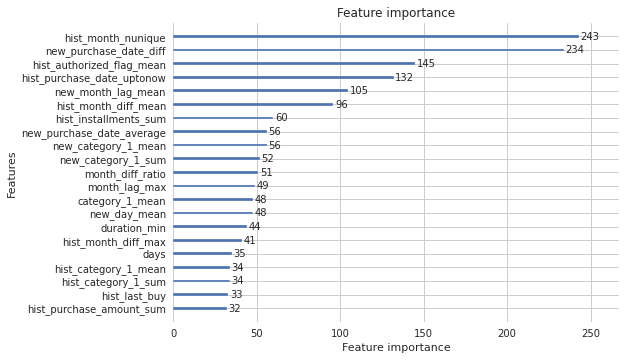

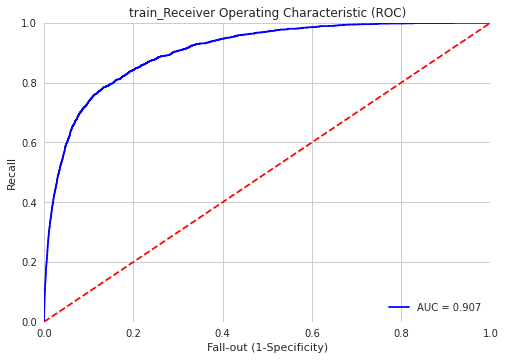

CPU times: user 58.2 s, sys: 4.94 s, total: 1min 3s
Wall time: 5min 33s


In [0]:
%%time
#https://www.kaggle.com/georsara1/light-gbm-solution-for-credit-fraud-detection
#Import modules
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
sns.set_style("whitegrid")

#Split in 75% train and 25% test set
train_x, test_x, train_y, test_y = train_test_split(train[df_train_columns],train['outliers'], test_size = 0.25, random_state= 1984)


#------------------------Build LightGBM Model-----------------------
train_data=lgb.Dataset(train_x, label=train_y)

#Select Hyper-Parameters
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.07,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 1.2,
          'reg_lambda': 1.2,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'
          }

# Create parameters to search
gridParams = {
    'learning_rate': [0.01, 0.03],
    'n_estimators': [2, 4, 6],
    'num_leaves': [10, 15],
    'boosting_type' : ['gbdt', 'rf'],
    'objective' : ['binary'],
    'random_state' : [501], 
    'colsample_bytree' : [0.70, 0.75, 0.80],
    'subsample' : [1, 1.2, 1.4],
    #'reg_alpha' : [1, 1.4, 1.6],
    #'reg_lambda' : [ 1.2, 1.6, 1.8],
    }

# Create classifier to use
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

# View the default model params:
mdl.get_params().keys()

# Create the grid
grid = GridSearchCV(mdl, gridParams, verbose=2, cv=4, n_jobs=-1)

# Run the grid
grid.fit(train_x, train_y)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

# Using parameters already set above, replace in the best from the grid search
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
# params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
#params['reg_alpha'] = grid.best_params_['reg_alpha']
#params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']
# params['subsample_for_bin'] = grid.best_params_['subsample_for_bin']

print('Fitting with params: ')
print(params)

#Train model on selected parameters and number of iterations
lgbm = lgb.train(params,
                 train_data,
                 280,
                 #early_stopping_rounds= 40,
                 verbose_eval= 4
                 )

#Predict on test set
predictions_lgbm_prob = lgbm.predict(test_x)
predictions_lgbm_01 = np.where(predictions_lgbm_prob > 0.5, 1, 0) #Turn probability to 0-1 binary output

#--------------------------Print accuracy measures and variable importances----------------------
#Plot Variable Importances
lgb.plot_importance(lgbm, max_num_features=21, importance_type='split')

#Print accuracy
acc_lgbm = accuracy_score(test_y,predictions_lgbm_01)
print('Overall accuracy of Light GBM model:', acc_lgbm)

#Print Area Under Curve for whole train
predictions_lgbm_prob = lgbm.predict(train[df_train_columns])
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(train['outliers'], predictions_lgbm_prob)
roc_auc = auc(false_positive_rate, recall)
plt.title('train_Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()


In [0]:
filename = '/content/drive/My Drive/Colab Notebooks/pkl_old/pkl/clf_prob_lgbm.sav'
#pickle.dump(lgbm, open(filename, 'wb'))
lgbm = pd.read_pickle(filename)

In [0]:
#Predict on test set
predictions_lgbm_prob_test = lgbm.predict(train[df_train_columns])
predictions_lgbm_prob_test.shape
predictions_lgbm_prob_test

(201917,)

array([0.0014579 , 0.00598069, 0.00354624, ..., 0.00411013, 0.01261649,
       0.00174198])

### 5.3.2 Regression model for target predicting

#### 1. Apply Light GBM Modelling Technique with Stratified K Folds enumerated on training set and outliers 

In [0]:
%%time
folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4950)
oof_2 = np.zeros(len(train))
features = df_train_columns
predictions_2 = np.zeros(len(test))
target1 = non_outliers['target']
feature_importance_df_2 = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(non_outliers[features].values, target1.values)):
    
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(non_outliers.iloc[trn_idx][features], label=target1.iloc[trn_idx])
    val_data = lgb.Dataset(non_outliers.iloc[val_idx][features], label=target1.iloc[val_idx])
    
    param ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 7,
                'top_rate': 0.9064148448434349,
                'num_leaves': 63,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':int(2**fold_),
                'bagging_seed':int(2**fold_),
                'drop_seed':int(2**fold_)
                }
        
    num_round = 10000
    clf_r = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 200)
    oof_2[val_idx] = clf_r.predict(train.iloc[val_idx][features], num_iteration=clf_r.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf_r.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df_2 = pd.concat([feature_importance_df_2, fold_importance_df], axis=0)
    
    predictions_2 += clf_r.predict(test[features], num_iteration=clf_r.best_iteration) / (5 * 2)


fold 0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[867]	training's rmse: 1.5212	valid_1's rmse: 1.55665
fold 1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[862]	training's rmse: 1.51963	valid_1's rmse: 1.56506
fold 2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[843]	training's rmse: 1.52121	valid_1's rmse: 1.56105
fold 3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[826]	training's rmse: 1.52165	valid_1's rmse: 1.56
fold 4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[845]	training's rmse: 1.51923	valid_1's rmse: 1.565
fold 5
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[864]	training's rmse: 1.51863	valid_1's rmse: 1.56649
fold 6
Training until validation scores don't 

In [0]:
filename = '/content/drive/My Drive/Colab Notebooks/pkl_old/pkl/clf_prob_lgbm2.sav'
#pickle.dump(clf_r, open(filename, 'wb'))
lgbm = pd.read_pickle(filename)

In [0]:
predictions_lgbm_prob_test.shape
oof_stack.shape
train.shape

(201917,)

(201917,)

(201917, 201)

In [0]:
predictions = lgbm.predict(train[df_train_columns], num_iteration=lgbm.best_iteration)
predictions.shape

(201917,)

In [0]:
train['binpredict'] = predictions_lgbm_prob_test
train['reg'] = predictions
train['target_f'] = train['binpredict']*(-33.21928) + train['reg']*(1-train['binpredict'])

### 5.3.3 Regression model new target

#### 1. Apply Light GBM Modelling Technique with Stratified K Folds enumerated on training set and outliers 

In [0]:
%%time
# Change in Hyper Parameters using kernel : https://www.kaggle.com/mfjwr1/simple-lightgbm-without-blending/output
import lightgbm as lgb
train = train
target = train['target_f']
folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=4950)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, train['outliers'].values)):
    
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])

    param ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 6,
                'top_rate': 0.9064148448434349,
                'num_leaves': 61,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':int(2**fold_),
                'bagging_seed':int(2**fold_),
                'drop_seed':int(2**fold_)
                }
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits
print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))
np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[100]	training's rmse: 0.603209	valid_1's rmse: 0.590478
fold 1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[976]	training's rmse: 0.209774	valid_1's rmse: 0.22899
fold 2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[121]	training's rmse: 0.544932	valid_1's rmse: 0.551039
fold 3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[105]	training's rmse: 0.58659	valid_1's rmse: 0.584752
fold 4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[409]	training's rmse: 0.274021	valid_1's rmse: 0.28907
CV score: 0.47545 
CPU times: user 6min 59s, sys: 1.71 s, total: 7min 1s
Wall time: 1min 57s


In [0]:
filename = '/content/drive/My Drive/Colab Notebooks/pkl_old/pkl/reg_lgbm1.sav'
pickle.dump(clf, open(filename, 'wb'))
#lgbm = pd.read_pickle(filename)

#### 2. Apply Light GBM Modelling Technique with Repeated K Folds enumerated on training set and Target 

In [0]:
folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4950)
oof_2 = np.zeros(len(train))
predictions_2 = np.zeros(len(test))
feature_importance_df_2 = pd.DataFrame()
features = df_train_columns
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train[df_train_columns].values, target.values)):
    
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])
    
    param ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 6,
                'top_rate': 0.9064148448434349,
                'num_leaves': 61,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':int(2**fold_),
                'bagging_seed':int(2**fold_),
                'drop_seed':int(2**fold_)
                }
        
    num_round = 10000
    clf_r = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 200)
    oof_2[val_idx] = clf_r.predict(train.iloc[val_idx][df_train_columns], num_iteration=clf_r.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf_r.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df_2 = pd.concat([feature_importance_df_2, fold_importance_df], axis=0)
    
    predictions_2 += clf_r.predict(test[df_train_columns], num_iteration=clf_r.best_iteration) / (5 * 2)

print("CV score: {:<8.5f}".format(mean_squared_error(oof_2, target)**0.5))

fold 0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1064]	training's rmse: 0.209353	valid_1's rmse: 0.225894
fold 1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[115]	training's rmse: 0.555084	valid_1's rmse: 0.569903
fold 2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[100]	training's rmse: 0.602447	valid_1's rmse: 0.604289
fold 3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[107]	training's rmse: 0.580768	valid_1's rmse: 0.580051
fold 4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[535]	training's rmse: 0.245168	valid_1's rmse: 0.253511
fold 5
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[100]	training's rmse: 0.599014	valid_1's rmse: 0.620713
fold 6
Training until valid

In [0]:
filename = '/content/drive/My Drive/Colab Notebooks/pkl_old/pkl/reg_lgbm2.sav'
pickle.dump(clf_r, open(filename, 'wb'))
#lgbm = pd.read_pickle(filename)

#### 4. Stacking models together.

In [0]:
from sklearn.linear_model import BayesianRidge

train_stack = np.vstack([oof,oof_2]).transpose()
test_stack = np.vstack([predictions, predictions_2]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=1, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions_3 = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3 = clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions_3 += clf_3.predict(test_stack) / 5
    
np.sqrt(mean_squared_error(target.values, oof_stack))


fold 0
fold 1
fold 2
fold 3
fold 4


0.36810195667596507

In [0]:
submission_name = pd.to_datetime("today")
sub_df = pd.DataFrame({"card_id":card_id})
sub_df["target"] = predictions_3
sub_df.to_csv('/content/final_submission_clf_reg.csv', index=False)
!kaggle competitions submit elo-merchant-category-recommendation -f '/content/final_submission_clf_reg.csv' -m "final_ipnb"

100% 4.24M/4.24M [00:10<00:00, 417kB/s]
Successfully submitted to Elo Merchant Category Recommendation

## Conclusions

In [4]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ['Model', 'train_RMSE', 'test_RMSE']
x.add_row(["LGBM+XGB stacked", "3.6324", "3.6492"])
x.add_row(["single LGBM model", "3.6345", "3.6498"])
x.add_row(["Separet outliers and classifier prob", "3.648", "3.661"])
x.add_row(["XGB", "3.645", "3.653"])
x.add_row(["Polynomial regression of deg 2", "3.806", "3.886"])
x.add_row(["Linear Regression", "3.744", "3.905"])
print(x)

+--------------------------------------+------------+-----------+
|                Model                 | train_RMSE | test_RMSE |
+--------------------------------------+------------+-----------+
|           LGBM+XGB stacked           |   3.6324   |   3.6492  |
|          single LGBM model           |   3.6345   |   3.6498  |
| Separet outliers and classifier prob |   3.648    |   3.661   |
|                 XGB                  |   3.645    |   3.653   |
|    Polynomial regression of deg 2    |   3.806    |   3.886   |
|          Linear Regression           |   3.744    |   3.905   |
+--------------------------------------+------------+-----------+


private score after Submission in kaggle


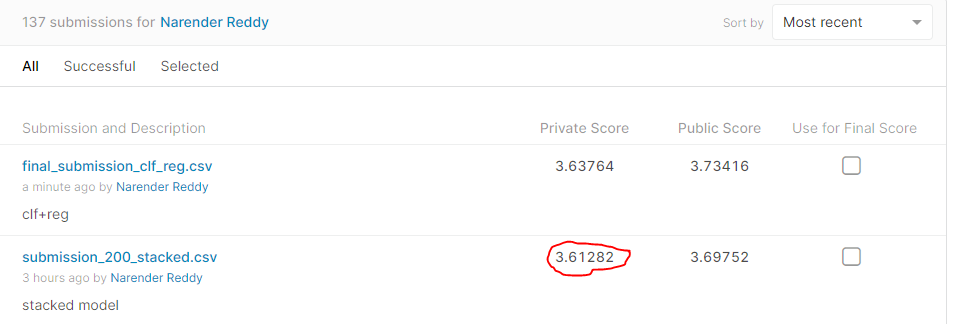

In [6]:
from IPython.display import Image
print("private score after Submission in kaggle")
Image("C:\\Users\\Narender Nani\\Downloads\\AAIC\\AAIC\\Solved assignments\\self case study1\\submission\\submission.PNG")

Leader board in top 7.5%


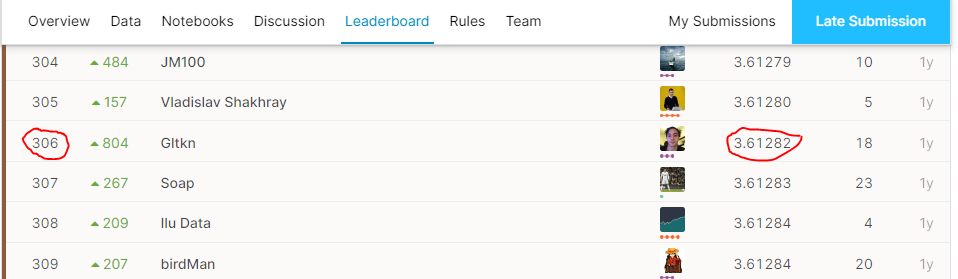

In [7]:
print("Leader board in top 7.5%")
Image("C:\\Users\\Narender Nani\\Downloads\\AAIC\\AAIC\\Solved assignments\\self case study1\\submission\\LB.PNG")

## FUTURE RESEARCH

1. Two approaches seem suitable: single lightGBM, stacked lgbm+xgb.

2. For all models, appropriate data preparation and feature selection is very important. Most
need transformation of ordinal categorical features by methods like One Hot Encoding.

3. Due to time constraints i was unable explore more but It is important in the problem to separate the outliers from the dataset and try to identify
these as a different distribution. Trying to create a reasonably accurate classifier for
outliers can greatly enhance the performance of models on the Elo dataset.

4. We can try linear stacking : train['final'] = train['bin_predict']*(-33.21928)+(1-train['bin_predict'])*train['no_outlier']
 can improve CV by 0.015 by 1st place(prob(classifier)**(-33.21928)+(1-prob(classifier)*regression_model)
